# ML CON REGRESION LINEAL - MEDICAL INSURANCE COST

Bibliotecas a utilizar

In [171]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler   # estandarizar variables
from sklearn.model_selection import train_test_split  #división de datos en entrenamiento y prueba
from sklearn.linear_model import Ridge


In [172]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
data = pd.read_csv(url)

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


EDA - Entender la estructura de los datos

In [173]:
print(data.shape)

(1338, 7)


In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### ¿Hay nulos?

In [175]:
print(data.isnull().sum())
print("No encontramos nulos en este DS")

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
No encontramos nulos en este DS


#### ¿Y duplicados?

In [176]:
duplicados = data.duplicated()
num_duplicados = duplicados.sum()
print(f"En este caso en contramos {num_duplicados} duplicados.")

En este caso en contramos 1 duplicados.


In [177]:
# Identificar las filas duplicadas
duplicados = data[data.duplicated(keep=False)]

# Mostrar las filas duplicadas
print(duplicados)

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [178]:
data = data.drop_duplicates()

# Confirmar que los duplicados han sido eliminados
num_duplicados = data.duplicated().sum()
print(f"Número de duplicados tras la limpieza: {num_duplicados}")

# Revisar el nuevo tamaño del dataset
print(f"Nuevo tamaño del dataset: {data.shape}")


Número de duplicados tras la limpieza: 0
Nuevo tamaño del dataset: (1337, 7)


In [179]:
data.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Información de las variables: 

- age: Edad del beneficiario principal (numérico)  
- sex: Género del beneficiario principal (categórico)  
- bmi: índice de masa corporal (numérico)
- children: Número de niños/dependientes cubiertos por un seguro médico (numérico)  
- smoker: ¿Es fumador? (categórico)  
- region: Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)  
- charges: Prima del seguro médico (numérico)  

In [180]:
# Contar las categorías en las variables categóricas
print(data['sex'].value_counts())
print(data['smoker'].value_counts())
print(data['region'].value_counts())


sex
male      675
female    662
Name: count, dtype: int64
smoker
no     1063
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


#### División de las variables en categóricas y numéricas 

In [181]:
# Identificar las variables numéricas
variables_numericas = data._get_numeric_data().columns
print("Las variables numéricas son:")
for var in variables_numericas:
    print(f" - {var}")

# Identificar las variables categóricas
variables_categoricas = set(data.columns) - set(variables_numericas)
print("\nLas variables categóricas son:")
for var in variables_categoricas:
    print(f" - {var}")


Las variables numéricas son:
 - age
 - bmi
 - children
 - charges

Las variables categóricas son:
 - region
 - sex
 - smoker


### Variables Categóricas

/tmp/ipykernel_643/2536602.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=var, palette='viridis', ax=ax)
/tmp/ipykernel_643/2536602.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=var, palette='viridis', ax=ax)
/tmp/ipykernel_643/2536602.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=var, palette='viridis', ax=ax)


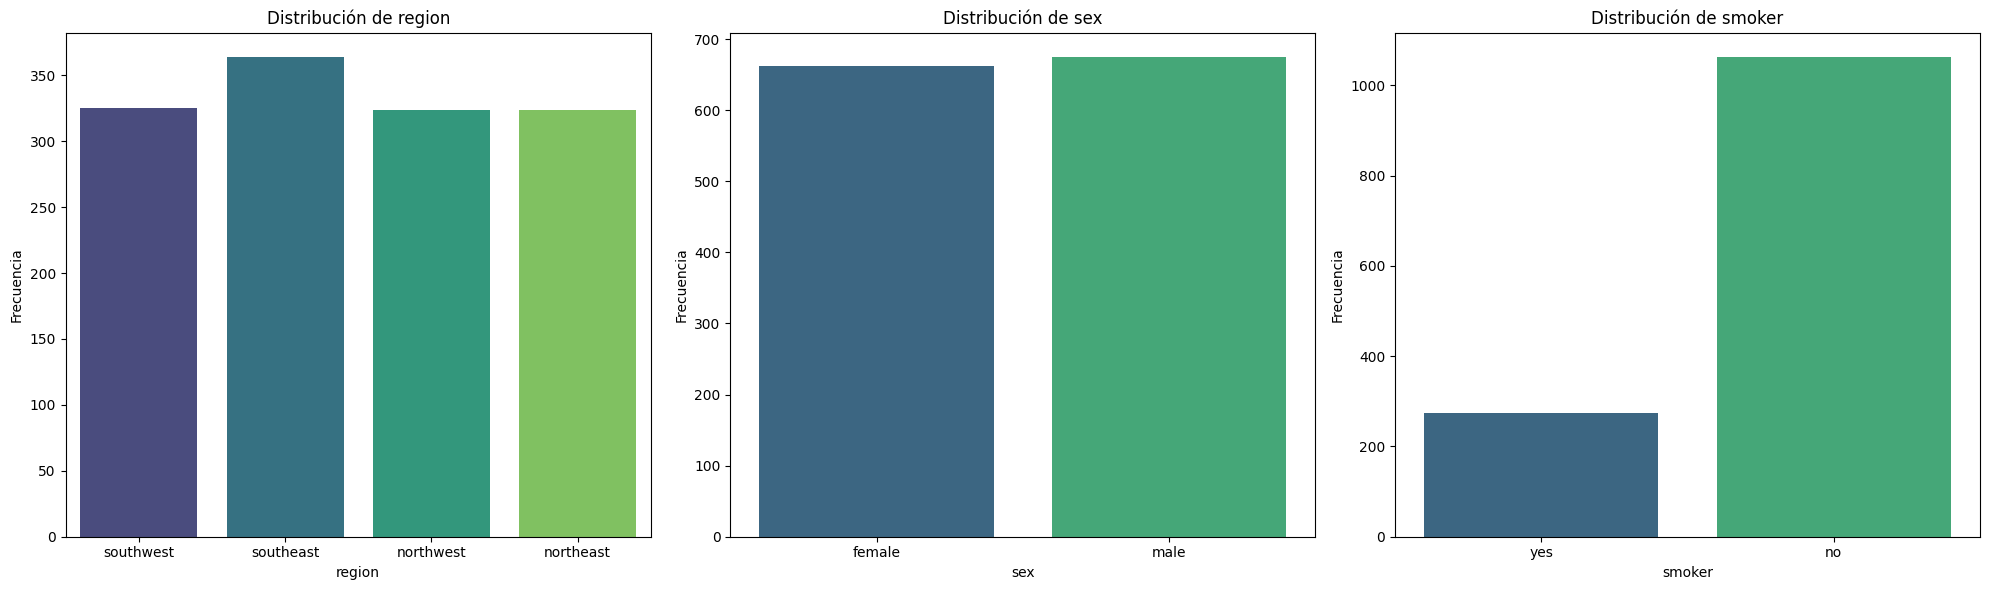

In [182]:
# Crear subplots
fig, axes = plt.subplots(nrows=1, ncols=len(variables_categoricas), figsize=(20, 6))

# Iterar sobre las variables categóricas y graficarlas
for ax, var in zip(axes, variables_categoricas):
    sns.countplot(data=data, x=var, palette='viridis', ax=ax)
    ax.set_title(f'Distribución de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')

# Ajustar el layout
plt.tight_layout()
plt.show()


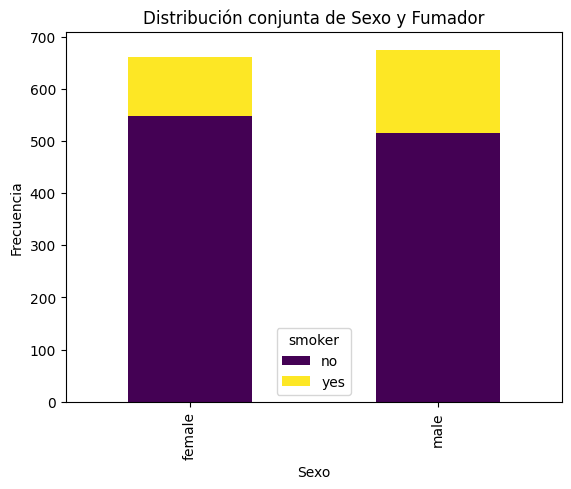

In [183]:
# Crear un gráfico de barras apiladas
contingencia = pd.crosstab(data['sex'], data['smoker'])
contingencia.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribución conjunta de Sexo y Fumador')
plt.xlabel('Sexo')
plt.ylabel('Frecuencia')
plt.show()


### Tratar las variables categóricas  'sex', 'smoker' y 'region' para nuestro modelo de regresión lineal

In [184]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##### Convertir variables binarias (sex, smoker)
 - Sex  --->    0 = MUJER   --- 1 = HOMBRE 
    
 - Smoker --->  0 = NO   --- 1 = SI      

In [185]:
# Convertir variables binarias a 0 y 1
data['sex'] = data['sex'].map({'female': 0, 'male': 1})
data['smoker'] = data['smoker'].map({'no': 0, 'yes': 1})

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


##### Usamos One-Hot encoding para dividir 'region' en columnas binarias.  
- El 1 significará que pertenece a esa región en cada una de las 4 columnas de cada región.


In [186]:
# Aplicamos One-Hot Enconding para 'region'
data_encoded = pd.get_dummies(data, columns=['region'], drop_first=False) #drop_first=True elimina la columna de referencia (region_northeast) / decido mantenerla con FALSE

#Pasamos el True/False a 0/1
data_encoded[['region_northwest', 'region_southeast', 'region_southwest', 'region_northeast']] = \
    data_encoded[['region_northwest', 'region_southeast', 'region_southwest', 'region_northeast']].astype(int)



In [187]:
print(data_encoded.head())

   age  sex     bmi  children  smoker      charges  region_northeast  \
0   19    0  27.900         0       1  16884.92400                 0   
1   18    1  33.770         1       0   1725.55230                 0   
2   28    1  33.000         3       0   4449.46200                 0   
3   33    1  22.705         0       0  21984.47061                 0   
4   32    1  28.880         0       0   3866.85520                 0   

   region_northwest  region_southeast  region_southwest  
0                 0                 0                 1  
1                 0                 1                 0  
2                 0                 1                 0  
3                 1                 0                 0  
4                 1                 0                 0  


### Variables numéricas

In [188]:
# Variables numéricas
variables_numericas = ['age', 'bmi', 'children', 'charges']

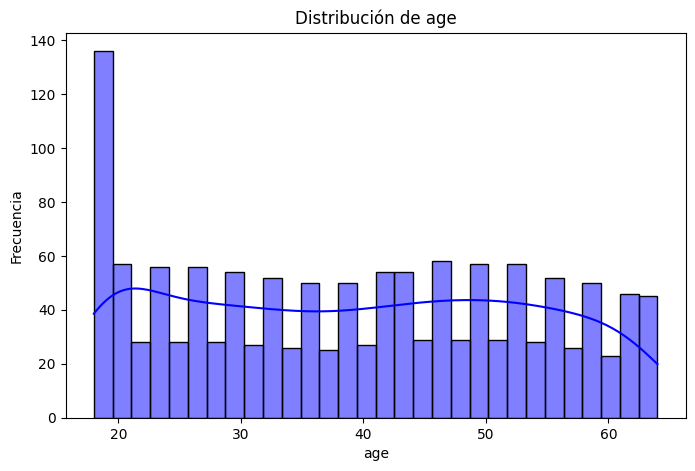

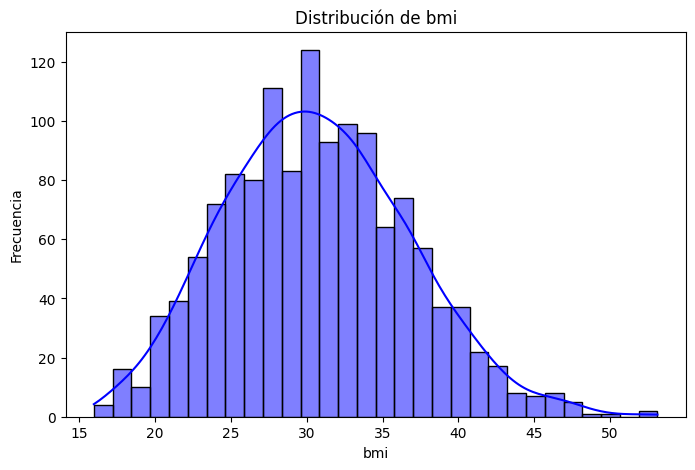

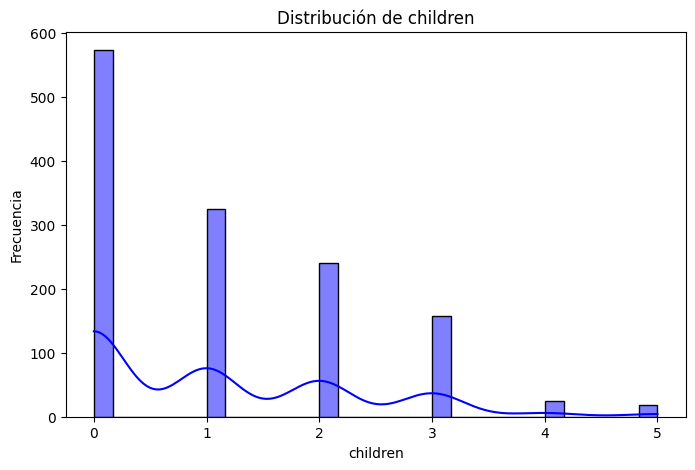

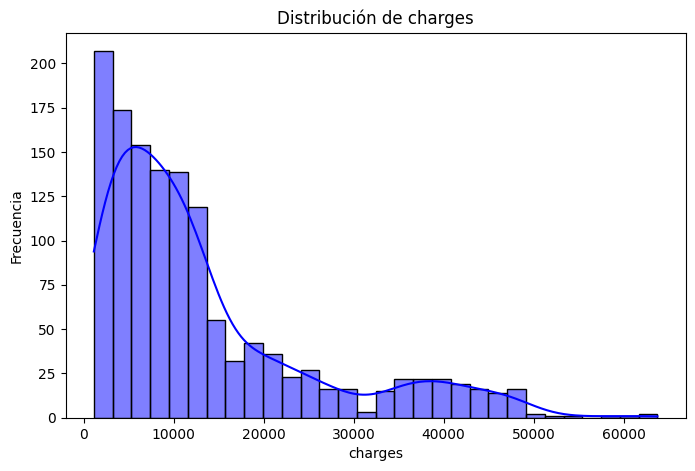

In [189]:
for var in variables_numericas:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[var], kde=True, bins=30, color='blue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

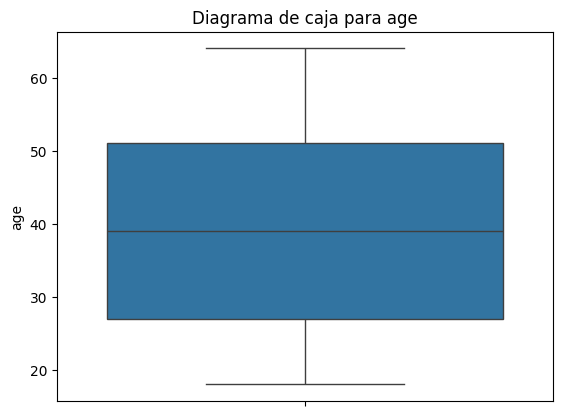

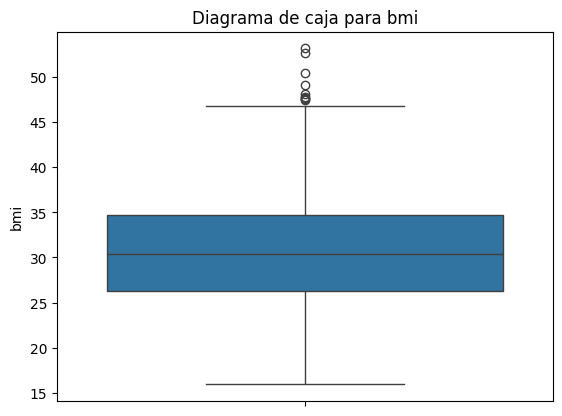

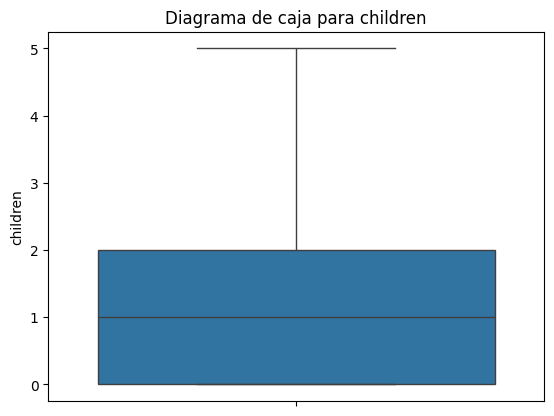

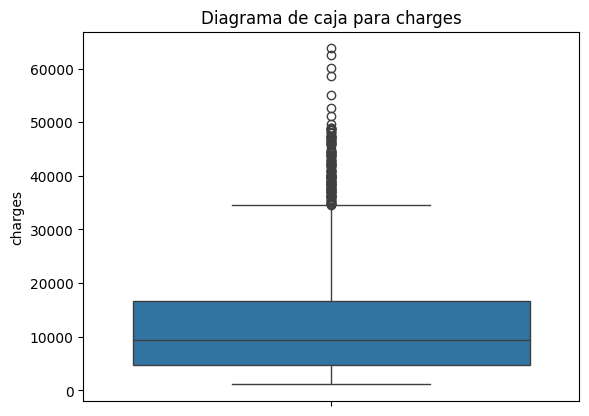

In [190]:
# Crear diagramas de caja para cada variable
for var in variables_numericas:
    sns.boxplot(data[var])
    plt.title(f'Diagrama de caja para {var}')
    plt.show()

#### Calculamos percentiles e IQR para trabajar outliers

In [191]:
# Definir una función para calcular outliers usando el IQR
def detect_outliers_iqr(data, column_name):
    """
    Detecta outliers en una columna usando el rango intercuartílico (IQR).
    Retorna los límites y el DataFrame de outliers.
    """
    Q1 = data[column_name].quantile(0.25)  # Percentil 25%
    Q3 = data[column_name].quantile(0.75)  # Percentil 75%
    IQR = Q3 - Q1  # Rango Intercuartílico

    # Calcular límites
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Filtrar los outliers
    outliers = data[(data[column_name] < lower_limit) | (data[column_name] > upper_limit)]

    return {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "lower_limit": lower_limit,
        "upper_limit": upper_limit,
        "outliers": outliers
    }



In [192]:
# Chequear outliers para "charges" y "bmi"
charges_outliers = detect_outliers_iqr(data, 'charges')
bmi_outliers = detect_outliers_iqr(data, 'bmi')

charges_outliers_summary = {
    "Límites charges": (charges_outliers['lower_limit'], charges_outliers['upper_limit']),
    "Número de outliers charges": len(charges_outliers['outliers'])
}

bmi_outliers_summary = {
    "Límites bmi": (bmi_outliers['lower_limit'], bmi_outliers['upper_limit']),
    "Número de outliers bmi": len(bmi_outliers['outliers'])
}

print(f"Para 'charges' vamos a mantener los outliers, ya que representan casos reales de personas con altos costes médicos que pueden ser relevantes: \n - {charges_outliers_summary}")
print(f"Para 'bmi' vamos a suavizar los outliers mediante la estandarización, no elimina los valores extremos pero asegura que no dominen el modelo: \n - {bmi_outliers_summary}")


Para 'charges' vamos a mantener los outliers, ya que representan casos reales de personas con altos costes médicos que pueden ser relevantes: 
 - {'Límites charges': (np.float64(-13120.716174999998), np.float64(34524.777625)), 'Número de outliers charges': 139}
Para 'bmi' vamos a suavizar los outliers mediante la estandarización, no elimina los valores extremos pero asegura que no dominen el modelo: 
 - {'Límites bmi': (np.float64(13.674999999999994), np.float64(47.31500000000001)), 'Número de outliers bmi': 9}


#### Chequear la columna 'bmi' y NO!! estandarizar

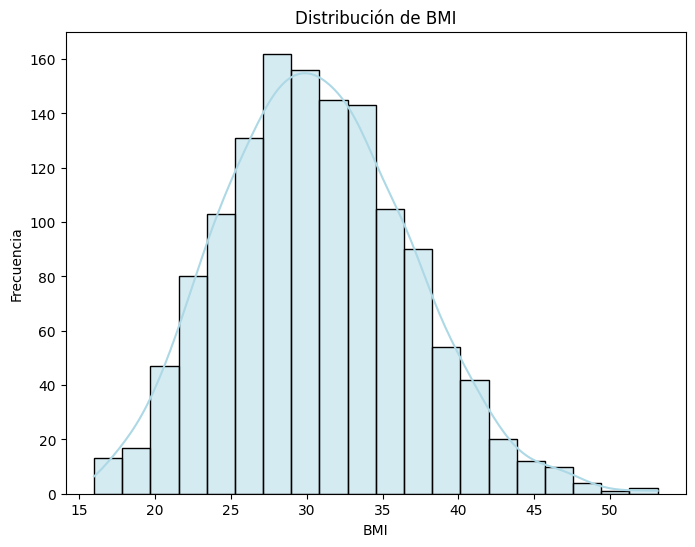

count    1337.000000
mean       30.663452
std         6.100468
min        15.960000
25%        26.290000
50%        30.400000
75%        34.700000
max        53.130000
Name: bmi, dtype: float64

In [193]:
# Mostrar estadísticas básicas y un histograma para visualizar los datos de BMI
bmi_stats = data['bmi'].describe()

# Histograma para visualizar la distribución de los datos
plt.figure(figsize=(8, 6))
sns.histplot(data['bmi'], kde=True, color='lightblue', bins=20)
plt.title('Distribución de BMI')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.show()

bmi_stats


In [194]:
#NO TIENE SENTIDO HACER ESTO

#scaler = StandardScaler()

# Usamos la columna 'bmi' y la aplicamos al escalador
#bmi_scaled = scaler.fit_transform(data[['bmi']])    # Los datos son transformados para tener media 0 y desviación estándar 1.

# Convertir el resultado a un DataFrame para visualizarlo
#bmi_scaled_df = pd.DataFrame(bmi_scaled, columns=['bmi_estandarizado'])

# Revisar la media y desviación estándar
#print(f"Media tras estandarización: {bmi_scaled_df['bmi_estandarizado'].mean():.2f}")
#print(f"Desviación estándar tras estandarización: {bmi_scaled_df['bmi_estandarizado'].std():.2f}")

# Agregar la columna escalada al dataset para su uso más adelante
#data['bmi_standarizado'] = bmi_scaled_df['bmi_estandarizado']



#### Graficamos para ver qué tal va todo antes del ML! = )

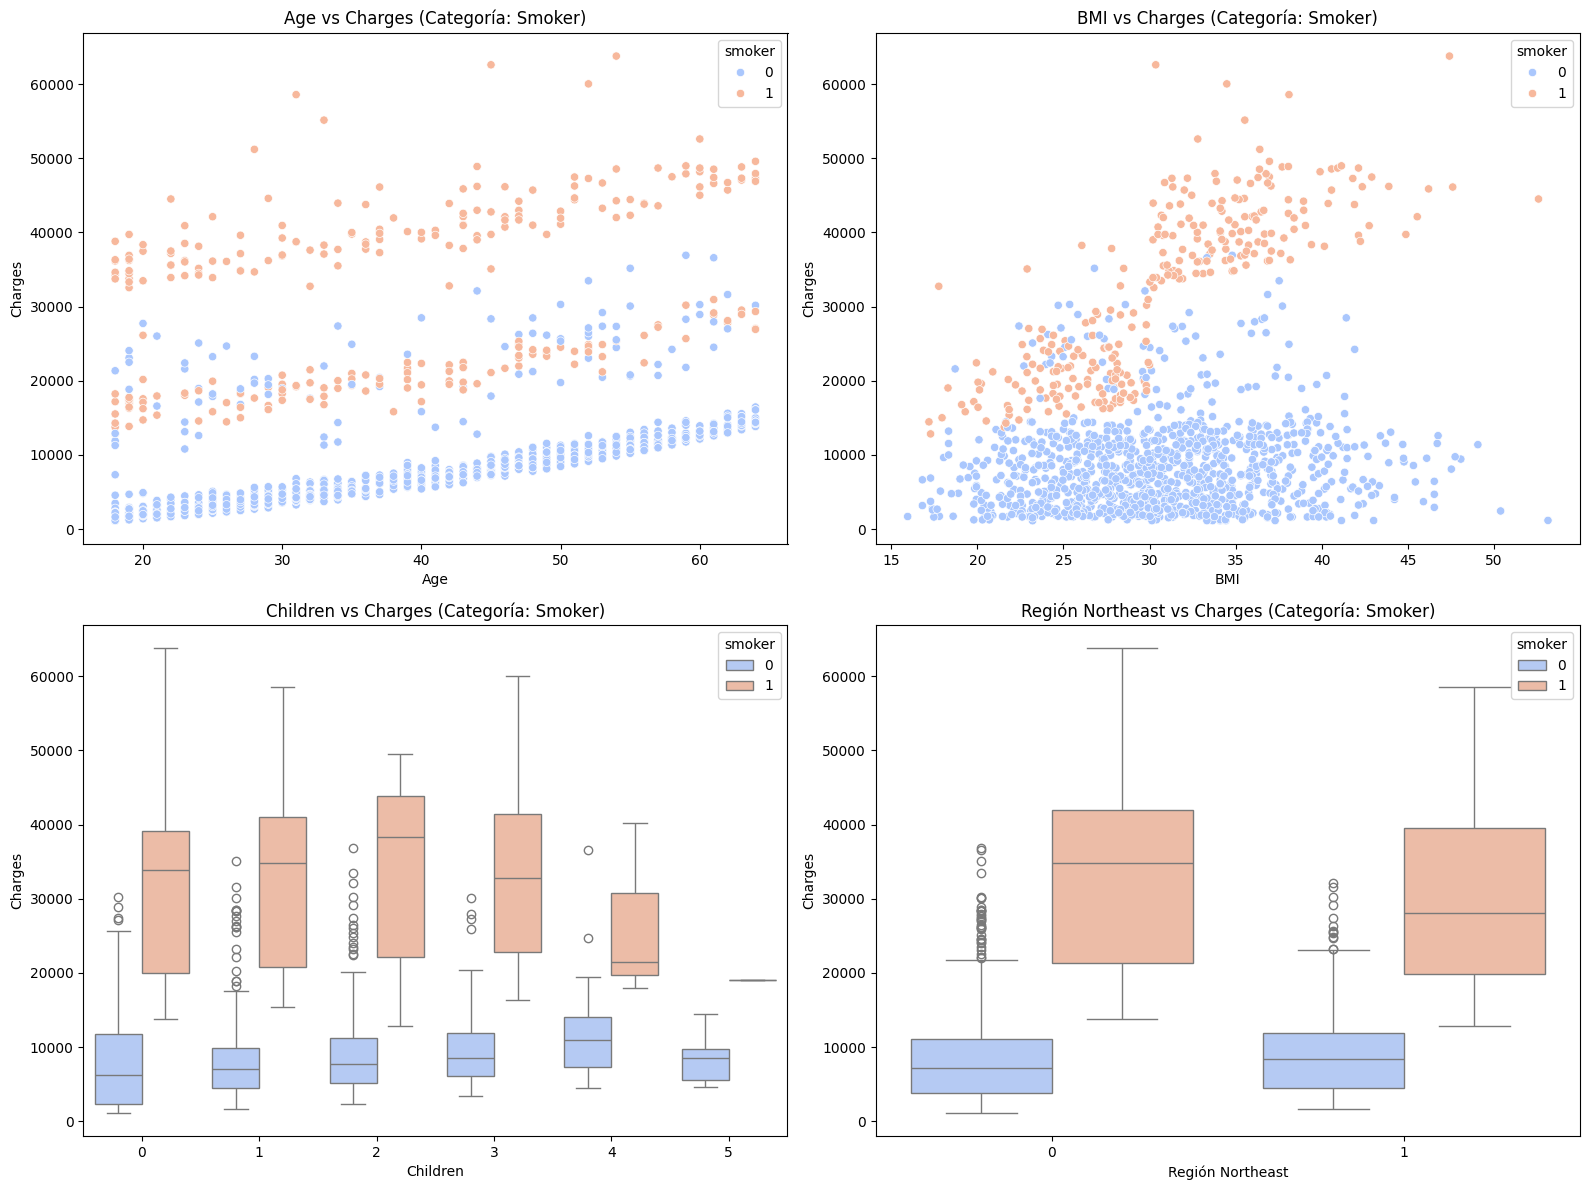

Me ha parecido interesante añadir la categoría de fumadores en todos los gráficos para ver cómo sube en general para este sector de la población el coste


In [195]:

# Tamaño de la figura
plt.figure(figsize=(16, 12))

# Relación entre `age` y `charges`
plt.subplot(2, 2, 1)
sns.scatterplot(data=data_encoded, x='age', y='charges', hue='smoker', palette='coolwarm')
plt.title('Age vs Charges (Categoría: Smoker)')
plt.xlabel('Age')
plt.ylabel('Charges')

# Relación entre `bmi` y `charges`
plt.subplot(2, 2, 2)
sns.scatterplot(data=data_encoded, x='bmi', y='charges', hue='smoker', palette='coolwarm')
plt.title('BMI vs Charges (Categoría: Smoker)')
plt.xlabel('BMI')
plt.ylabel('Charges')

# Relación entre `children` y `charges`
plt.subplot(2, 2, 3)
sns.boxplot(data=data_encoded, x='children', y='charges', hue='smoker', palette='coolwarm')
plt.title('Children vs Charges (Categoría: Smoker)')
plt.xlabel('Children')
plt.ylabel('Charges')

# Relación entre regiones y `charges`
plt.subplot(2, 2, 4)
sns.boxplot(data=data_encoded, x='region_northeast', y='charges', hue='smoker', palette='coolwarm')
plt.title('Región Northeast vs Charges (Categoría: Smoker)')
plt.xlabel('Región Northeast')
plt.ylabel('Charges')

plt.tight_layout()
plt.show()

print("Me ha parecido interesante añadir la categoría de fumadores en todos los gráficos para ver cómo sube en general para este sector de la población el coste")


### División de los datos en entrenamiento y prueba

Cuando construimos un modelo de machine learning, queremos:  

- Entrenar el modelo: Usar una parte de los datos (conjunto de entrenamiento) para que el modelo aprenda patrones y relaciones en los datos.  
  
- Evaluar el modelo: Usar otra parte de los datos (conjunto de prueba) que el modelo no ha visto para evaluar su capacidad de generalización.  
  
Esto ayuda a evitar el problema de overfitting (cuando el modelo se ajusta demasiado a los datos de entrenamiento y no funciona bien con datos nuevos).

In [196]:
# Variables predictoras (X) y variable objetivo (y)
X = data_encoded.drop(columns=['charges'])  # Todas las columnas excepto 'charges'
y = data_encoded['charges']  # Variable objetivo

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Revisar las dimensiones de los conjuntos resultantes
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")


Conjunto de entrenamiento: (1069, 9), (1069,)
Conjunto de prueba: (268, 9), (268,)


#### Entrenamiento del modelo en Regresión Lineal

1. Entrenar el modelo:  
  
- Usamos el conjunto de entrenamiento para ajustar el modelo de regresión lineal.
- Esto significa que el modelo aprenderá a predecir charges basándose en las relaciones entre las variables independientes (age, bmi, etc.) y la variable objetivo.  
    
      
2. Evaluar el modelo:  
  
- Comprobamos qué tan bien predice el modelo usando el conjunto de prueba.  
- Calculamos métricas como el Error Cuadrático Medio (MSE) y el R² para medir la precisión.


In [197]:
# Crea una instancia del modelo regresión Lineal
model = LinearRegression()

# Entrenar el modelo con el conjunto de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones del conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#resultados
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Coeficiente de determinación (R²): {r2:.2f}")


Error Cuadrático Medio (MSE): 35478020.68
Coeficiente de determinación (R²): 0.81


#### Graficamos para ver la predicción real VS los valores reales.

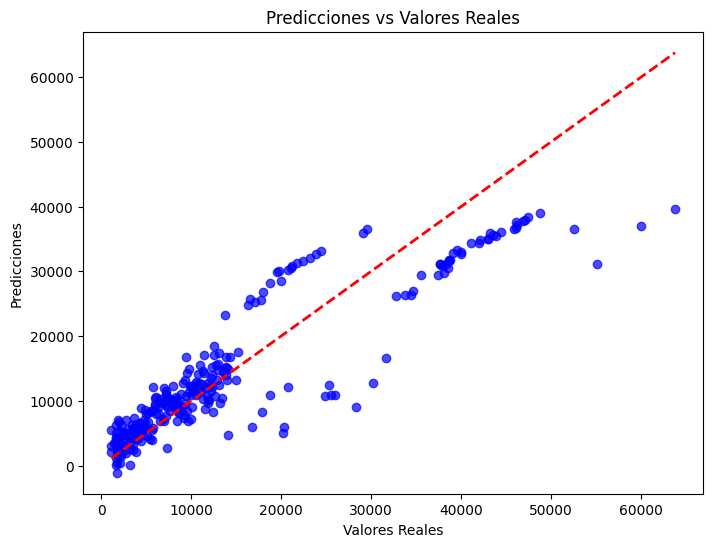

In [198]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Línea perfecta
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

Analizamos para intentar mejorarlo. 

In [199]:
# Coeficientes del modelo
coeficientes = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
}).sort_values(by='Coeficiente', ascending=False)

print(coeficientes)


           Variable   Coeficiente
4            smoker  23077.764593
3          children    533.009989
5  region_northeast    472.455206
2               bmi    318.701441
0               age    248.210720
6  region_northwest     80.693751
1               sex   -101.542054
8  region_southwest   -186.684546
7  region_southeast   -366.464410


#### Transformación logarítmica en charges para reducir el impacto de valores extremos / luego me he enterado de que es mejor no hacer esto - la variable Y HAY QUE DEJARLA EN PAZ

In [200]:
# Transformar charges
y_log = np.log1p(y)  # log(1 + charges)

# Dividir los datos de nuevo
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Entrenar el modelo nuevamente
model.fit(X_train, y_train)
y_pred_log = model.predict(X_test)

# Evaluar en escala logarítmica
mse_log = mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)

print(f"MSE (log-scale): {mse_log:.2f}")
print(f"R² (log-scale): {r2_log:.2f}")


MSE (log-scale): 0.16
R² (log-scale): 0.83


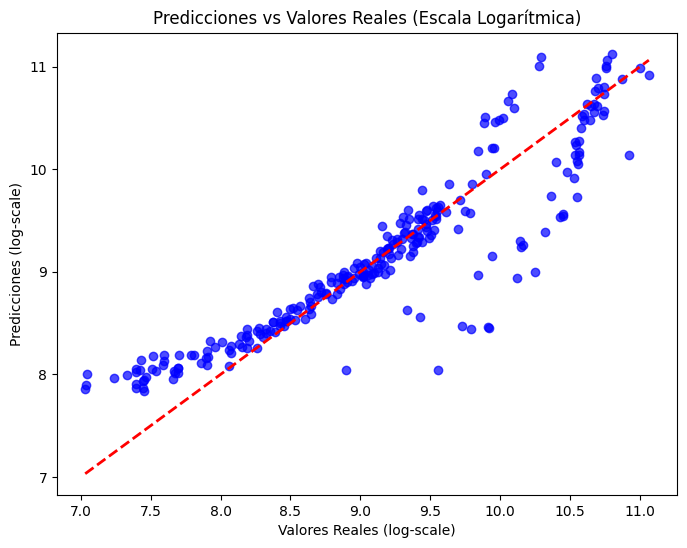

MSE (log-scale): 0.16
R² (log-scale): 0.83


In [201]:
# Graficar Predicciones vs Valores Reales (en escala logarítmica)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_log, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicciones vs Valores Reales (Escala Logarítmica)")
plt.xlabel("Valores Reales (log-scale)")
plt.ylabel("Predicciones (log-scale)")
plt.show()

print(f"MSE (log-scale): {mse_log:.2f}")
print(f"R² (log-scale): {r2_log:.2f}")

### Seguimos investigando

ANALIZAR RESIDUOS  
--  Qué buscar:

- Residuos simétricos y centrados en 0 indican un buen modelo.
- Un patrón claro sugiere que el modelo no está capturando ciertas relaciones.

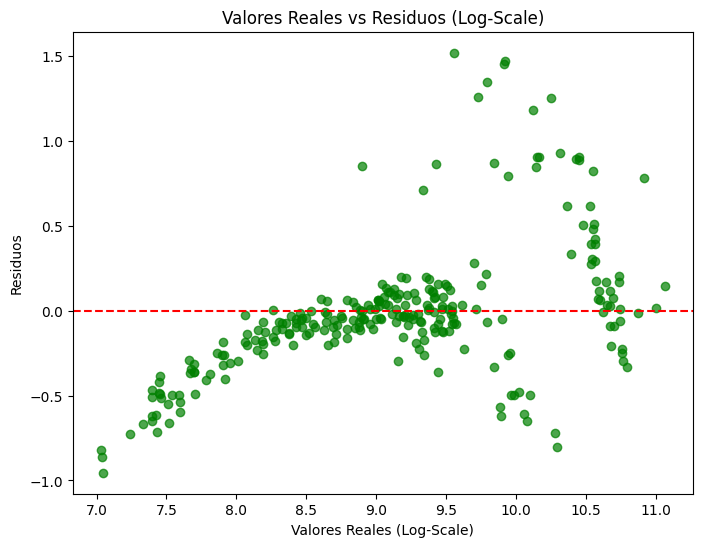

In [202]:
residuos = y_test - y_pred_log

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuos, alpha=0.7, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Valores Reales vs Residuos (Log-Scale)")
plt.xlabel("Valores Reales (Log-Scale)")
plt.ylabel("Residuos")
plt.show()


1.  INCLUIR INTERACCIONES ENTRE VARIABLES CLAVE  

- Fumadores con alto BMI suelen tener un impacto mucho mayor en los costes (smoker * bmi_estandarizado).  
- Edad avanzada combinada con ser fumador podría tener un efecto distinto (smoker * age).

In [203]:
# Crear interacciones entre variables clave
X['smoker_bmi'] = X['smoker'] * X['bmi']
X['smoker_age'] = X['smoker'] * X['age']


In [204]:
# Dividir los datos en entrenamiento y prueba nuevamente
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Entrenar el modelo con las nuevas interacciones
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones con el modelo actualizado
y_pred_log = model.predict(X_test)

# Evaluar el modelo actualizado
mse_log = mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)

# Mostrar los resultados
print(f"MSE (log-scale): {mse_log:.2f}")
print(f"R² (log-scale): {r2_log:.2f}")


MSE (log-scale): 0.12
R² (log-scale): 0.87


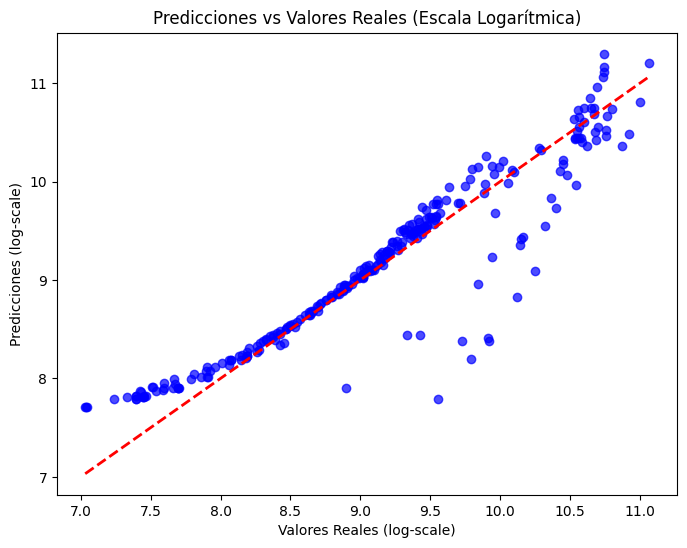

MSE (log-scale): 0.12
R² (log-scale): 0.87


In [205]:
# Graficar Predicciones vs Valores Reales (en escala logarítmica)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_log, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicciones vs Valores Reales (Escala Logarítmica)")
plt.xlabel("Valores Reales (log-scale)")
plt.ylabel("Predicciones (log-scale)")
plt.show()

print(f"MSE (log-scale): {mse_log:.2f}")
print(f"R² (log-scale): {r2_log:.2f}")

In [206]:


# Crear y entrenar el modelo Ridge con un alpha inicial
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo Ridge
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Mostrar los resultados de Ridge
print(f"MSE (Ridge): {mse_ridge:.2f}")
print(f"R² (Ridge): {r2_ridge:.2f}")


MSE (Ridge): 0.12
R² (Ridge): 0.87


In [207]:
coef_original = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
}).sort_values(by='Coeficiente', ascending=False)
print(coef_original)


            Variable  Coeficiente
4             smoker     1.203375
3           children     0.109085
5   region_northeast     0.067882
9         smoker_bmi     0.053955
0                age     0.041282
6   region_northwest     0.032280
2                bmi     0.000228
10        smoker_age    -0.034015
7   region_southeast    -0.042825
8   region_southwest    -0.057337
1                sex    -0.086290


Pero no hace nada :( , he probado a elijminar todas menos norheast y luego todas, pero el resultado es el mismo.

In [208]:


X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Crear y entrenar el modelo nuevamente
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_log = model.predict(X_test)

# Evaluar el modelo
mse_log = mean_squared_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)

# Mostrar los resultados
print(f"MSE (log-scale): {mse_log:.2f}")
print(f"R² (log-scale): {r2_log:.2f}")


MSE (log-scale): 0.12
R² (log-scale): 0.87


Aquí me quedo :(

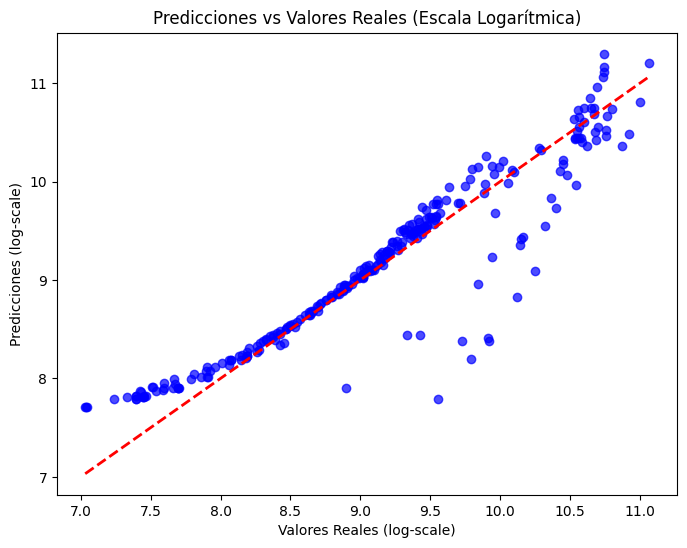

MSE (log-scale): 0.12
R² (log-scale): 0.87


In [209]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_log, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicciones vs Valores Reales (Escala Logarítmica)")
plt.xlabel("Valores Reales (log-scale)")
plt.ylabel("Predicciones (log-scale)")
plt.show()

print(f"MSE (log-scale): {mse_log:.2f}")
print(f"R² (log-scale): {r2_log:.2f}")

### Conclusión

Aplicando el logaritmo a "y" nos acercaríamos más pero no sería del todo correcto ya que alteraríamos el valor que necesitamos predecir y menos hablando del ámbito médico donde no deberíamos quitar esos extremos que pueden ser importantes a la hora de presupuestar, el resto de variables seleccionadas apenas afectan al modelo.